# Zeropoint and sky Background and ADC counts for LSSTComCamSim

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-05-11
- last update : 2024-05-11
- affiliation : IJCLab/IN2P3/CNRS

In [1]:
import os
import sys
from pathlib import Path
from pprint import pprint

from scipy import interpolate
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.colors import ListedColormap
from matplotlib import colors

In [2]:
from IPython.display import Image

In [3]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [4]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Set environment for USDF Rubin Science Platform


In [5]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data.data_sets import  get_data_dir
from rubinsimphot.phot_utils import PhotometricParameters 

## Configuration

### Configuration of input path

In [6]:
atmosphere_std_filename = "atmos_std.dat"

hardware_filenames = ["hardware_u.dat","hardware_g.dat","hardware_r.dat","hardware_i.dat","hardware_z.dat","hardware_y.dat"] 
filter_filenames = ["filter_u.dat","filter_g.dat","filter_r.dat","filter_i.dat","filter_z.dat","filter_y.dat" ]
total_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Z","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

FILTERWL = np.array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

### Configuration of telescope/camera photometric parameters

In [7]:
DT = 30.0 # Exposure time in seconds
gel = 1.693343125
#hP = 6.62607015E-34 # J⋅Hz−1
hP = 6.626196E-27
A  = np.pi*642.3**2/4 # cm2  Reff=6.423 m
pixel_scale = 0.2 #arcsec/pixel
readnoise = 12.3936875

def set_photometric_parameters(exptime, nexp, readnoise=readnoise):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [8]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

In [9]:
photoparams = set_photometric_parameters(DT, 1 , readnoise=readnoise )
photoparams._gain = gel
photoparams._exptime = DT
photoparams._effarea = A
photoparams._platescale = pixel_scale

## Read input files

In [10]:
fdir = get_data_dir()
print(f"path for input data : {fdir}")
# path for Bandpass for lsstsim : throughputs/baseline
path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'baseline')

path for input data : /home/d/dagoret/repos/repos_w_2024_17/rubinsimphot/src/rubin_sim_data


### Atmospheric transmission

In [11]:
atm_fullfilename = os.path.join(path_rubin_sim_throughput,atmosphere_std_filename)
arr= np.loadtxt(atm_fullfilename)
atm = Bandpass(wavelen=arr[:,0],sb=arr[:,1])

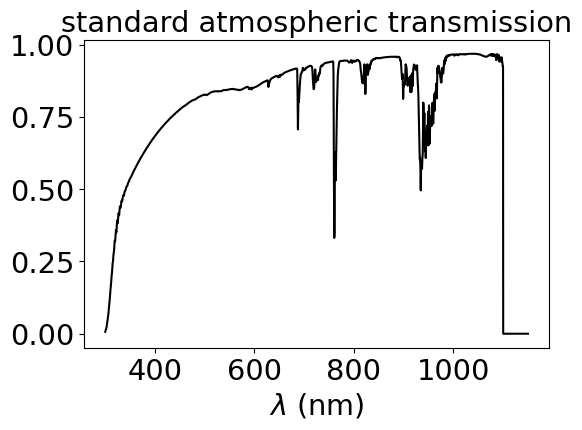

In [12]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(atm.wavelen,atm.sb,color="k")   
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_title("standard atmospheric transmission")
plt.show()

### Instrumental Filter , no atmosphere

In [13]:
bandpass_inst = {}
for index,filename in enumerate(hardware_filenames):
    fullfilename=os.path.join(path_rubin_sim_throughput,filename)
    arr= np.loadtxt(fullfilename)
    fname = filter_tagnames[index]
    bandpass_inst[fname] = Bandpass(wavelen=arr[:,0],sb=arr[:,1])

Text(0.5, 1.0, 'Instrument throughput')

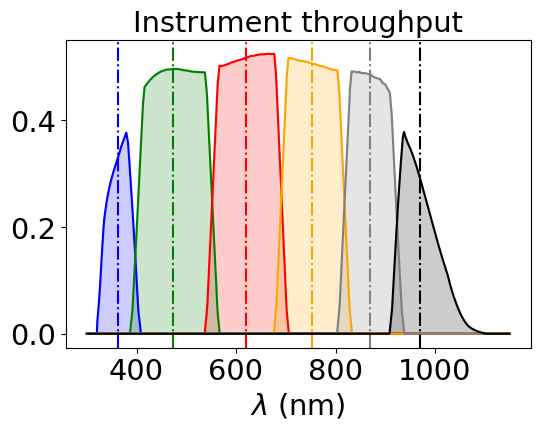

In [14]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames): 
    axs.plot(bandpass_inst[f].wavelen,bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(bandpass_inst[f].wavelen,bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput")


### total Filter , with atmosphere

In [15]:
bandpass_total = {}
for index,filename in enumerate(total_filenames):
    fullfilename=os.path.join(path_rubin_sim_throughput,filename)
    arr= np.loadtxt(fullfilename)
    fname = filter_tagnames[index]
    bandpass_total[fname] = Bandpass(wavelen=arr[:,0],sb=arr[:,1])

Text(0.5, 1.0, 'Total throughput')

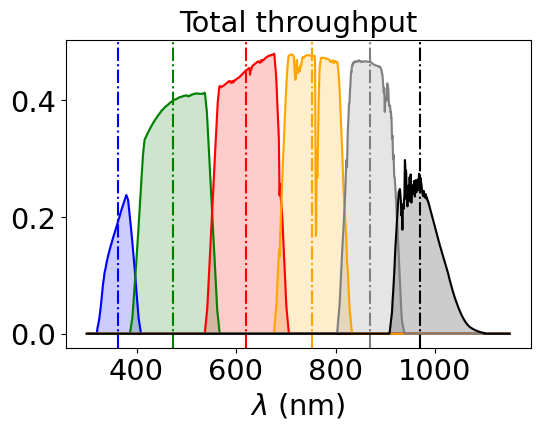

In [16]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames): 
    axs.plot(bandpass_total[f].wavelen,bandpass_total[f].sb,color=filter_color[index]) 
    axs.fill_between(bandpass_total[f].wavelen,bandpass_total[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total throughput")

## Source Count in an AB-Source

### Info from LSE-40

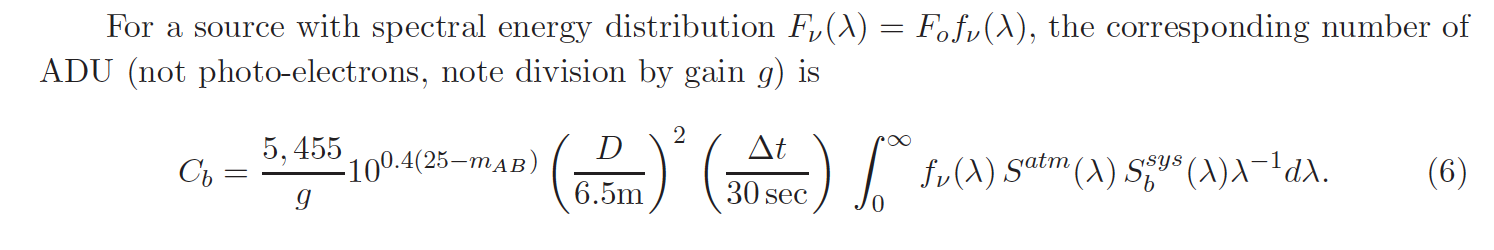

In [17]:
Image(filename='./images/CbRateFull.png',width=800)

### Calculate Magnitude for the flat SED

In [18]:
sed_flat = Sed()
sed_flat.set_flat_sed()
flux_norm = sed_flat.calc_flux_norm(0, bandpass_total['g'])
sed_flat.multiply_flux_norm(flux_norm)

In [19]:
wl,fnu = sed_flat.get_sed_fnu()
wl,fl = sed_flat.get_sed_flambda()

Text(0.5, 1.0, 'Flat SED')

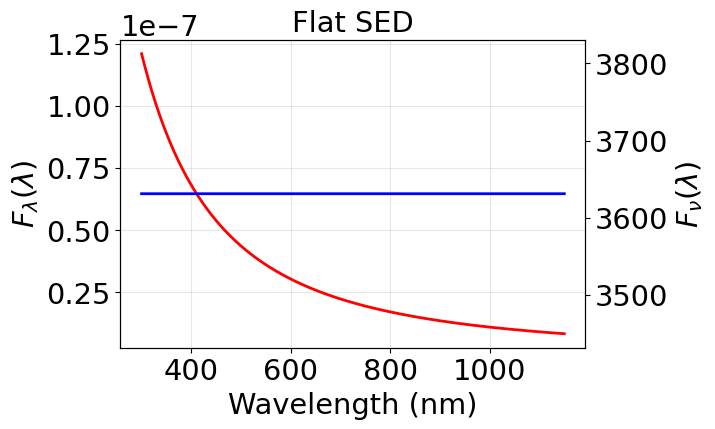

In [20]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(wl, fl,"-",color="r",label = "$f_\lambda$",lw=2)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\lambda (\lambda)$")

ax2 =ax.twinx()
ax2.plot(wl, fnu,"-",color="b",label = "$f_\nu$",lw=2)
ax2.set_ylabel("$F_\\nu (\lambda)$")

ax.set_title("Flat SED")

#### AB source mag 

In [21]:
# Calculate the standard AB source mag - for reference
AB_mags = {}

for index,f in enumerate(filter_tagnames):
    AB_mags[f] = sed_flat.calc_mag(bandpass_total[f])
    
pd.DataFrame(AB_mags, index=['AB source mag']).round(2)

,u,g,r,i,z,y
AB source mag,0.0,0.0,0.0,0.0,0.0,0.0


#### AB source ADU rate (per pixel per second)

In [22]:
# Need to select an exposure of 1 second as the zero-point refers to a flux of 1 ADU/sec
photoparams._exptime = 1.0

In [23]:
pprint(vars(photoparams))

{'_bandpass': None,
 '_darkcurrent': 0.2,
 '_effarea': 324015.4546769212,
 '_exptime': 1.0,
 '_gain': 1.693343125,
 '_nexp': 1,
 '_othernoise': 0.0,
 '_platescale': 0.2,
 '_readnoise': 12.3936875,
 '_sigma_sys': 0.005}


In [24]:
# Calculate the standard zero magnitudes - for reference
AB_adu = {}

for index,f in enumerate(filter_tagnames):
    AB_adu[f] = sed_flat.calc_adu(bandpass_total[f],photoparams)
    
pd.DataFrame(AB_adu, index=['AB source ADU/pix/s']).round(2)

,u,g,r,i,z,y
AB source ADU/pix/s,3.495485e+10,1.278432e+11,1.055983e+11,8.087212e+10,5.633156e+10,2.719261e+10


### Magnitude 20 source (per pixel per second)

In [25]:
flux_norm = sed_flat.calc_flux_norm(20, bandpass_total['g'])
sed_flat.multiply_flux_norm(flux_norm)

In [26]:
# Calculate the standard dark sky zenith magnitudes - for reference
AB_adu = {}

for index,f in enumerate(filter_tagnames):
    AB_adu[f] = sed_flat.calc_adu(bandpass_total[f],photoparams)
    
pd.DataFrame(AB_adu, index=['AB-mag20 source ADU/pix/s']).round(2)

,u,g,r,i,z,y
AB-mag20 source ADU/pix/s,349.55,1278.43,1055.98,808.72,563.32,271.93


## Zero Point

### Info from note LSE-40

In [27]:
Image(filename='./images/ZeroPointFormula.png')

FileNotFoundError: [Errno 2] No such file or directory: './Images/ZeroPointFormula.png'

In [ ]:
Image(filename='./images/CbRateShort.png',width=500)

In [ ]:
Image(filename='./images/Tb.png',width=400)

In [ ]:
Image(filename='./images/LSSTCountRates.png')

In [ ]:
# Need to select an exposure of 1 second as the zero-point refers to a flux of 1 ADU/sec
photoparams._exptime = 1.0

In [ ]:
pprint(vars(photoparams))

In [ ]:
# Calculate the standard dark sky zenith magnitudes - for reference
zeropoint_mags = {}

for index,f in enumerate(filter_tagnames):
   
    zp = bandpass_total[f].calc_zp_t(photoparams)
    zeropoint_mags[f] = zp
    
pd.DataFrame(zeropoint_mags, index=['ZP (mag)']).round(2)

## Sky Background

### Get Sky Spectrum
https://github.com/sylvielsstfr/rubinsimphot/blob/main/src/rubinsimphot/phot_utils/sed.py

In [ ]:
darksky = Sed()
darksky.read_sed_flambda(os.path.join(path_rubin_sim_throughput, 'darksky.dat'))

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(darksky.wavelen,darksky.flambda,'r-')
#axs.plot(darksel.wavelen,darksel.flambda,'b-')
axs.set_title("sky background SED")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_ylabel("$F_\lambda (\lambda)$")

### Dark-Sky Magnitude

#### Info from LSE-40

In [ ]:
Image(filename='./images/SEDSkyBackground.png')

In [ ]:
Image(filename='./images/LSSTSkyBackground.png')

In [ ]:
Image(filename='./images/MagnitudeSkyBackground.png')

#### Calculation from rubinsimphot

In [ ]:
# Calculate the standard dark sky zenith magnitudes - for reference
darksky_mags = {}

for index,f in enumerate(filter_tagnames):
    darksky_mags[f] = darksky.calc_mag(bandpass_inst[f])
    
pd.DataFrame(darksky_mags, index=['Dark-Sky mag/arcsec']).round(2)

### Info from note LSE-40

In [ ]:
Image(filename='./images/LSSTCountRates.png')

In [ ]:
Image(filename='./images/Bb.png',width=800)

In [ ]:
Image(filename='./images/Sigmab.png',width=200)

### Dark-Sky ADU/sec

In [ ]:
# need to specify an exposure of 1 second as in the above tables counts are per second
photoparams._exptime = 1. 
pprint(vars(photoparams))

In [ ]:
# Calculate the standard dark sky zenith magnitudes - for reference
darksky_adu = {}

for index,f in enumerate(filter_tagnames):
    darksky_adu[f] = darksky.calc_adu(bandpass_inst[f],photoparams)
    
pd.DataFrame(darksky_adu, index=['Dark-Sky ADU/pix/s']).round(2)

### Dark-Sky ADU/exposure

In [ ]:
photoparams._exptime = 30. 
pprint(vars(photoparams))

In [ ]:
# Calculate the standard dark sky zenith magnitudes - for reference
darksky_adu_expo = {}

for index,f in enumerate(filter_tagnames):
    darksky_adu_expo[f] = darksky.calc_adu(bandpass_inst[f],photoparams)
    
pd.DataFrame(darksky_adu_expo, index=['Dark-Sky ADU/pix/expo']).round(2)